In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report


In [2]:
# Load the annotated dataset
dataset = pd.read_csv('tai.csv')


In [3]:
dataset

,label,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x29,y29,x30,y30,x31,y31,x32,y32,x33,y33
0,Tame,259,120,267,108,271,108,275,108,251,...,123,595,489,597,126,606,522,610,109,626
1,Bow-Arrow,207,82,210,78,211,78,213,78,209,...,177,242,281,246,184,251,273,254,159,253
2,Bow-Arrow,233,85,241,73,246,72,251,71,230,...,133,501,499,505,147,520,478,520,82,526
3,Bow-Arrow,352,124,346,114,345,114,344,114,346,...,116,409,391,409,101,411,454,406,123,433
4,Bow-Arrow,174,179,181,165,184,165,187,165,179,...,89,636,643,662,111,673,640,691,32,668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Sitting,593,347,596,327,600,325,604,323,592,...,751,634,646,564,758,614,611,592,791,674
57,Sitting,304,119,302,99,302,99,302,99,294,...,352,546,88,521,346,575,106,574,457,587
58,Sitting,277,83,284,64,287,63,290,62,282,...,531,527,256,578,548,498,160,589,554,589
59,Taijiquan,389,116,398,100,402,100,408,101,381,...,272,680,461,680,277,691,479,731,267,735


In [4]:
# Apply stripping function to all elements in the DataFrame

dataset = dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)

C:\Users\john\AppData\Local\Temp\ipykernel_12484\4251743574.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset = dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)


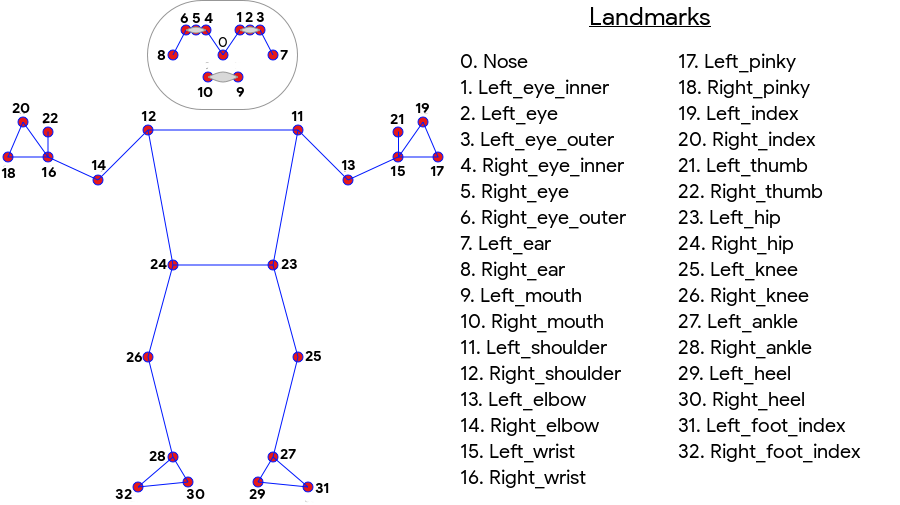

In [5]:
from IPython.display import Image

Image(filename='33 landmarks.png') 

In [6]:
# Define a function to calculate the angle between three keypoints
def get_angle(row, keypoint_1, keypoint_2, keypoint_3):
    # Extract the x and y coordinates of the keypoints
    a = np.array([row['x' + str(keypoint_1)], row['y' + str(keypoint_1)]])  # First
    b = np.array([row['x' + str(keypoint_2)], row['y' + str(keypoint_2)]])  # Mid
    c = np.array([row['x' + str(keypoint_3)], row['y' + str(keypoint_3)]])  # End

    # Calculate the vectors between the keypoints
    ba = a - b
    bc = c - b

    # Calculate the cosine of the angle
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

    # Calculate the angle in degrees
    angle = math.degrees(np.arccos(cosine_angle))

    # Ensure the angle is between 0 and 180 degrees
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

# Define the list of keypoints you want to calculate angles for
keypoints = [11, 12, 23, 24, 25, 26, 27, 28]

# Apply the get_angle function to your DataFrame for each combination of keypoints
dataset['angle'] = dataset.apply(lambda row: get_angle(row, keypoints[0], keypoints[1], keypoints[2]), axis=1)
# Repeat the above line for other combinations of keypoints if needed.


In [7]:
print(dataset)

        label   x1   y1   x2   y2   x3   y3   x4   y4   x5  ...  y29  x30  \
0        Tame  259  120  267  108  271  108  275  108  251  ...  595  489   
1   Bow-Arrow  207   82  210   78  211   78  213   78  209  ...  242  281   
2   Bow-Arrow  233   85  241   73  246   72  251   71  230  ...  501  499   
3   Bow-Arrow  352  124  346  114  345  114  344  114  346  ...  409  391   
4   Bow-Arrow  174  179  181  165  184  165  187  165  179  ...  636  643   
..        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
56    Sitting  593  347  596  327  600  325  604  323  592  ...  634  646   
57    Sitting  304  119  302   99  302   99  302   99  294  ...  546   88   
58    Sitting  277   83  284   64  287   63  290   62  282  ...  527  256   
59  Taijiquan  389  116  398  100  402  100  408  101  381  ...  680  461   
60       Tame  262   85  266   74  270   75  274   75  254  ...  523  465   

    y30  x31  y31  x32  y32  x33  y33       angle  
0   597  126  606  522 

In [8]:
# Get the number of rows and columns
num_rows, num_columns = dataset.shape

print(f'Number of rows: {num_rows}')
print(f'Number of columns: {num_columns}')

Number of rows: 61
Number of columns: 68


In [9]:
unique_values = dataset['label'].unique()
print(unique_values)

['Tame' 'Bow-Arrow' 'False Stance' 'Four-Six' 'Golden Rooster'
 'Horse Stance' 'Sitting' 'Taijiquan']


In [10]:
# Extract labels
labels = dataset["label"]

# Extract keypoint data including the 'angle' column
keypoints = dataset.drop("label", axis=1).values


In [11]:
# Normalize the keypoints (optional but often helpful)
keypoints = (keypoints - keypoints.mean()) / keypoints.std()

In [12]:
# Convert labels to numerical values (you may need to encode them appropriately)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


Split the dataset into training and testing sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(keypoints, labels, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(48, 67) (48,) (13, 67) (13,)


Define the RNN model

In [14]:
class KeypointRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(KeypointRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        return out

# Define model hyperparameters
input_size = 67  # The number of features in your dataset
hidden_size = 64  # Number of units in the RNN layer
num_layers = 10  # Number of RNN layers
num_classes = 8

# Initialize the model
model = KeypointRNN(input_size, hidden_size, num_layers, num_classes)



Prepare data for training

In [15]:
# Convert the training data to PyTorch tensors
X_train = torch.Tensor(X_train).view(-1, 1, input_size)
y_train = torch.LongTensor(y_train)

# Create a DataLoader for training
train_data = TensorDataset(X_train, y_train)
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


Define loss function and optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Train the model

In [17]:
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients before calculating the loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}")

print("Training complete!")


Epoch [1/10] Loss: 2.1612
Epoch [2/10] Loss: 2.1122
Epoch [3/10] Loss: 2.0651
Epoch [4/10] Loss: 2.0171
Epoch [5/10] Loss: 1.9657
Epoch [6/10] Loss: 1.9087
Epoch [7/10] Loss: 1.8442
Epoch [8/10] Loss: 1.7706
Epoch [9/10] Loss: 1.6877
Epoch [10/10] Loss: 1.5971
Training complete!


Evaluate the model

In [18]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    X_test = torch.Tensor(X_test).view(-1, 1, input_size)
    y_test = torch.LongTensor(y_test)
    outputs = model(X_test)
    
    _, predicted = torch.max(outputs, 1)
    y_true = y_test.numpy()
    y_pred = predicted.numpy()

    correct = (y_true == y_pred).sum()  # Count the number of correct predictions
    total = len(y_test)  # Total number of predictions

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


model.train()  # Set the model back to training mode


Test Accuracy: 53.85%


KeypointRNN(
  (rnn): RNN(67, 64, num_layers=10, batch_first=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)

In [19]:
class_names = ["Class1", "Class2", "Class3", "Class4", "Class5", "Class6", "Class7", ]


In [20]:
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    X_test = torch.Tensor(X_test).view(-1, 1, input_size)
    y_test = torch.LongTensor(y_test)
    outputs = model(X_test)
    
    _, predicted = torch.max(outputs, 1)
    y_true = y_test.numpy()
    y_pred = predicted.numpy()

# Calculate classification metrics
classification_metrics = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

print("Classification Report:")
print(classification_metrics)

model.train()  # Set the model back to training mode


Classification Report:
              precision    recall  f1-score   support

      Class1       0.00      0.00      0.00         1
      Class2       0.00      0.00      0.00         1
      Class3       0.00      0.00      0.00         1
      Class4       0.54      1.00      0.70         7
      Class5       0.00      0.00      0.00         1
      Class6       0.00      0.00      0.00         1
      Class7       0.00      0.00      0.00         1

    accuracy                           0.54        13
   macro avg       0.08      0.14      0.10        13
weighted avg       0.29      0.54      0.38        13



KeypointRNN(
  (rnn): RNN(67, 64, num_layers=10, batch_first=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)

In [21]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true, y_pred)
print(mcc)

0.0


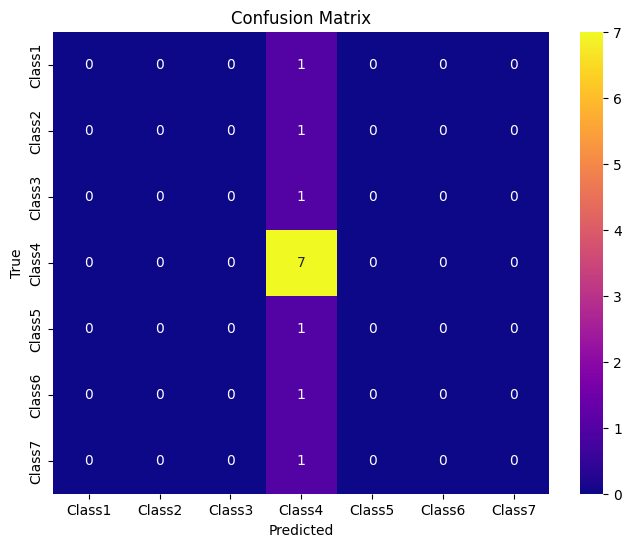

KeypointRNN(
  (rnn): RNN(67, 64, num_layers=10, batch_first=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)

In [22]:

# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

model.train()  # Set the model back to training mode

In [23]:
# Specify the file path where you want to save the model
model_path = "keypoint_rnn_model.pth"

# Save the model's state dictionary to the specified file
torch.save(model.state_dict(), model_path)

In [24]:
# Load the saved model
model.load_state_dict(torch.load('keypoint_rnn_model.pth'))
model.eval()  # Set the model to evaluation mode

KeypointRNN(
  (rnn): RNN(67, 64, num_layers=10, batch_first=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)

In [27]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

# Load your saved model
model = KeypointRNN(input_size, hidden_size, num_layers, num_classes)
model.load_state_dict(torch.load('keypoint_rnn_model.pth'))
model.eval()  # Set the model to evaluation mode

# Ensure that X_test is properly formatted
X_test = torch.Tensor(X_test).view(-1, 1, input_size)
y_test = torch.LongTensor(y_test)

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Make predictions and record true labels
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    true_labels = y_test.numpy()
    predicted_labels = predicted.numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
mcc = matthews_corrcoef(true_labels, predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)

# Print the evaluation results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print("Confusion Matrix:")
print(confusion)

# Optionally, you can visualize the confusion matrix or other results
# For confusion matrix visualization, you can use libraries like Seaborn or Matplotlib

# Set the model back to training mode if needed
model.train()

Accuracy: 53.85%
Precision: 0.0769
Recall: 0.1429
F1-Score: 0.1000
Matthews Correlation Coefficient (MCC): 0.0000
Confusion Matrix:
[[0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 7 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]]


c:\Users\john\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeypointRNN(
  (rnn): RNN(67, 64, num_layers=10, batch_first=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)